In [13]:
import pandas as pd
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression

In [14]:
weather_data = pd.read_csv('../../../data/Plant_1_Weather_Sensor_Data.csv')
gen_data = pd.read_csv('../../../data/Plant_1_Generation_Data.csv')
weather_data['DATE_TIME']= pd.to_datetime(weather_data['DATE_TIME'])
gen_data['DATE_TIME']= pd.to_datetime(gen_data['DATE_TIME'])

In [15]:
weather_data['DAY'] = pd.DatetimeIndex(weather_data['DATE_TIME']).dayofyear
weather_data['TIME'] = weather_data.DATE_TIME.dt.hour * 60 + weather_data.DATE_TIME.dt.minute
weather_data['Time'] = weather_data.DATE_TIME.dt.time
weather_data['HOUR'] = weather_data.DATE_TIME.dt.hour
weather_data.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DAY,TIME,Time,HOUR
0,2020-05-15 00:00:00,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,136,0,00:00:00,0
1,2020-05-15 00:15:00,4135001,HmiyD2TTLFNqkNe,25.084589,22.761668,0.0,136,15,00:15:00,0
2,2020-05-15 00:30:00,4135001,HmiyD2TTLFNqkNe,24.935753,22.592306,0.0,136,30,00:30:00,0
3,2020-05-15 00:45:00,4135001,HmiyD2TTLFNqkNe,24.846130,22.360852,0.0,136,45,00:45:00,0
4,2020-05-15 01:00:00,4135001,HmiyD2TTLFNqkNe,24.621525,22.165423,0.0,136,60,01:00:00,1


In [16]:
merged_df = pd.merge(gen_data, weather_data, how='inner', on=['DATE_TIME'], suffixes=('', '_y'))
merged_df.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,PLANT_ID_y,SOURCE_KEY_y,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DAY,TIME,Time,HOUR
0,2020-05-15,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,136,0,00:00:00,0
1,2020-05-15,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,136,0,00:00:00,0
2,2020-05-15,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,136,0,00:00:00,0
3,2020-05-15,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,136,0,00:00:00,0
4,2020-05-15,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,136,0,00:00:00,0


In [17]:
merged_df['DC_cumulative']=merged_df.groupby(['SOURCE_KEY', 'DAY'])['DC_POWER'].cumsum()
merged_df['AC_cumulative']=merged_df.groupby(['SOURCE_KEY', 'DAY'])['AC_POWER'].cumsum()

## Daily yield reflects the daily inefficiencies fo inverters, since if an inverter has not been performing well the whole day the total yield is going to be lower for that inverter

<AxesSubplot:xlabel='DAY', ylabel='DAILY_YIELD'>

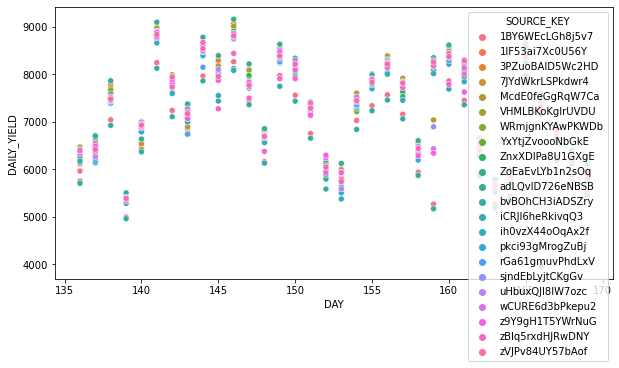

In [18]:
plt.figure(figsize=(10, 5))
sns.scatterplot(data=pd.DataFrame(merged_df.groupby(['DAY', 'SOURCE_KEY'])['DAILY_YIELD'].max()).reset_index(), x='DAY', y='DAILY_YIELD', hue='SOURCE_KEY')

## BUT
1. it's unclear how is this variable defined. It seems to be neither the cumulative sum of AC nor the cumulative sum of DC
2. If it is some kind of output of AC power from inverters it means it also contains artifacts of DC to AC conversion inefficiencies (and maybe also some others), which we want to be able to separate from the DC conversion anomalies
3. Additionally it is lagged or smoothed with respect to the AC power. See the second plot.

We could in alternative just take the cumulative of DC power to derive the inefficient inverters of each day, however
1. we would still need to exclude the outliers manually (like in current setup), because we also want to be able to give alarms from sudden failures
2. the sum is a less robust measure for our purposes than is the fit. A drop to 0 at midday for half an hour could have equivalent effect on the daily yield as a small drop for a few hours. we need to be able to distinguish between these and we want to identify only very long term efficiency drops that have had effect on the behaviour of the whole day not just few hours. These are the cases that the fit can capture better.
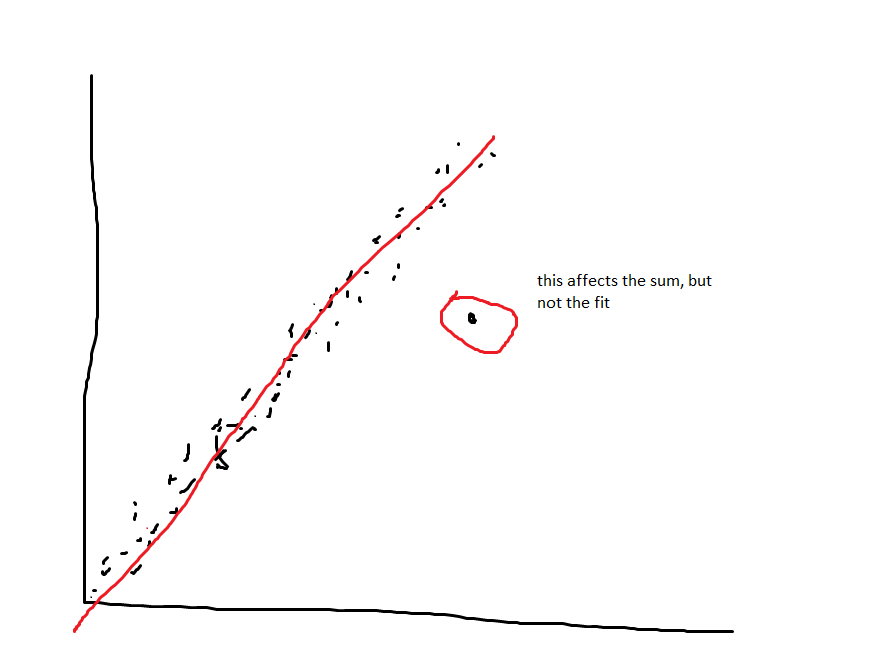

In [22]:
%matplotlib qt
#plt.plot(merged_df[merged_df['DAY']==136]['DATE_TIME'], merged_df[merged_df['DAY']==136]['DC_cumulative']/4, '.')
plt.plot(merged_df[merged_df['DAY']==136]['DATE_TIME'], merged_df[merged_df['DAY']==136]['AC_cumulative']/4, '.')
plt.plot(merged_df[(merged_df['DAY']==136)]['DATE_TIME'], merged_df[merged_df['DAY']==136]['DAILY_YIELD'], '.')


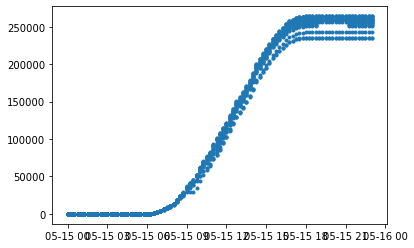

In [9]:
plt.plot(merged_df[merged_df['DAY']==136]['DATE_TIME'], merged_df[merged_df['DAY']==136]['DC_cumulative'], '.')

In [25]:
%matplotlib qt
plt.plot(merged_df[(merged_df['DAY']==136)&(merged_df['SOURCE_KEY']=='1BY6WEcLGh8j5v7')]['DATE_TIME'], merged_df[(merged_df['DAY']==136)&(merged_df['SOURCE_KEY']=='1BY6WEcLGh8j5v7')]['DAILY_YIELD'], '.')
plt.plot(merged_df[(merged_df['DAY']==136)&(merged_df['SOURCE_KEY']=='1BY6WEcLGh8j5v7')]['DATE_TIME'], merged_df[(merged_df['DAY']==136)&(merged_df['SOURCE_KEY']=='1BY6WEcLGh8j5v7')]['AC_POWER'].cumsum()/4, '.')